### Meng Wang

# MTH9875 Homework 7

Assigned: October 13, 2016.
Due: October 27, 2016 by 6pm.

Late homework **will not be accepted**.

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this iPython notebook to Victor Istratov (stavka@gmail.com), Yassine Ghalem (yassine.ghalem@gmail.com) and Jim Gatheral (jim.gatheral@gmail.com) by the due date and time.  All R-code must run correctly and solutions must be written up neatly in Markdown/LaTeX format.

### 0. (0 points) 

Read the Schoutens et al. paper.

### Load some R-code and data

In [1]:
download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/10/9875-HW7.zip", destfile="9875-HW7.zip")
unzip(zipfile="9875-HW7.zip")

In [2]:
source("BlackScholes.R")
source("Heston2.R")
source("plotIvols.R")
source("bsvolPhi.R")

For problem 1. you will need SPX implied vols as of the close on September 15, 2005.

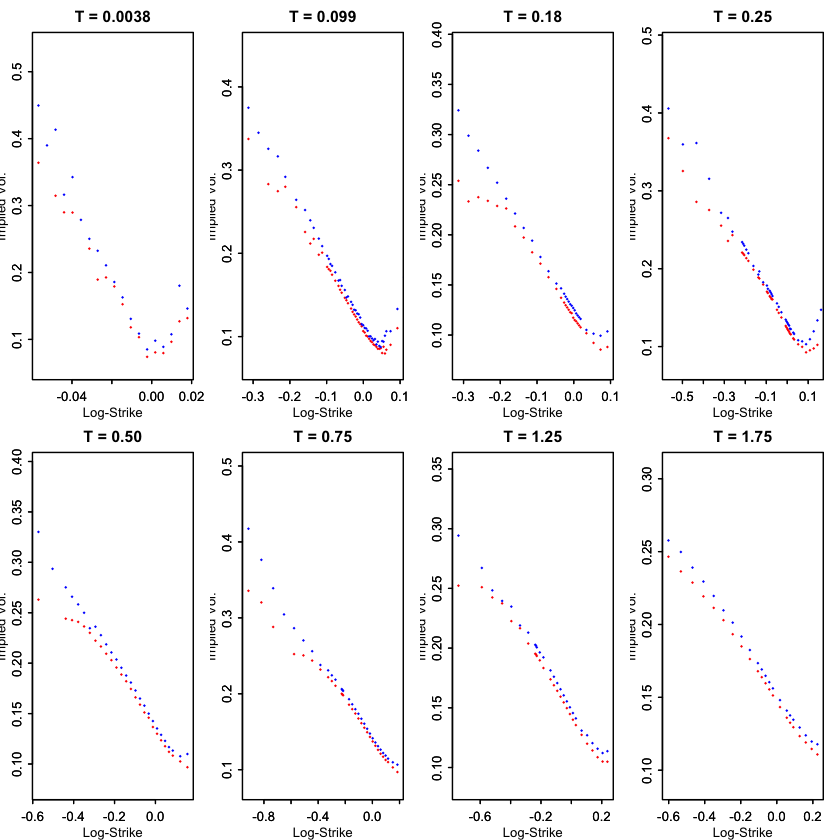

In [3]:
load("spx050915.rData") 

# Plot the resulting implied volatilities
res <- plotIvols(spxOptData) 

As usual, assume zero interest rates and dividends for the following
assignments.

## Comparison of Heston and SVJ fits to the SPX volatility surface

### 1. (12 points)
$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
%\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\BS}{\text{BS}}
\newcommand{\ee}[1]{{\mathbb{E}\left[{#1}\right]}}
\newcommand{\eef}[1]{{\mathbb{E}\left[\left.{#1}\right|\cF_t\right]}}
\newcommand{\eefm}[2]{{\mathbb{E}^{#2}\left[\left.{#1}\right|\cF_t\right]}}
$$

Consider the following fits of the Heston and SVJ models to the SPX volatility surface as of 15-Sep-2005:

  |Heston|SVJ|
-----|-----:|-------:|
$v$ |0.0174 | 0.0158
$\bar v$ | 0.0354|  0.0439
$\eta$ |  0.3877|0.3038
$\rho$  | -0.7165 |-0.6974 
$\lambda$ |1.3253|0.5394 
$\lambda_J$| |0.1308
$\delta$ | |0.0967 
$\alpha$ ||-0.1151 

(a)

Using the function *bsvolPhi*, *phiHeston*, and the SVJ characteristic function code *phiSVJ* from Lecture 7, superimpose Heston and SVJ 1 year smiles with log-strikes from -1 to +1 with the above parameters. 

(b)

Amend the function *plotIvols()* to superimpose Heston and SVJ smiles on the implied volatility smiles computed from the raw option data. 

(c)

Comment briefly on the fits in a style suitable for your non-mathematical manager.

### Answer
(a)

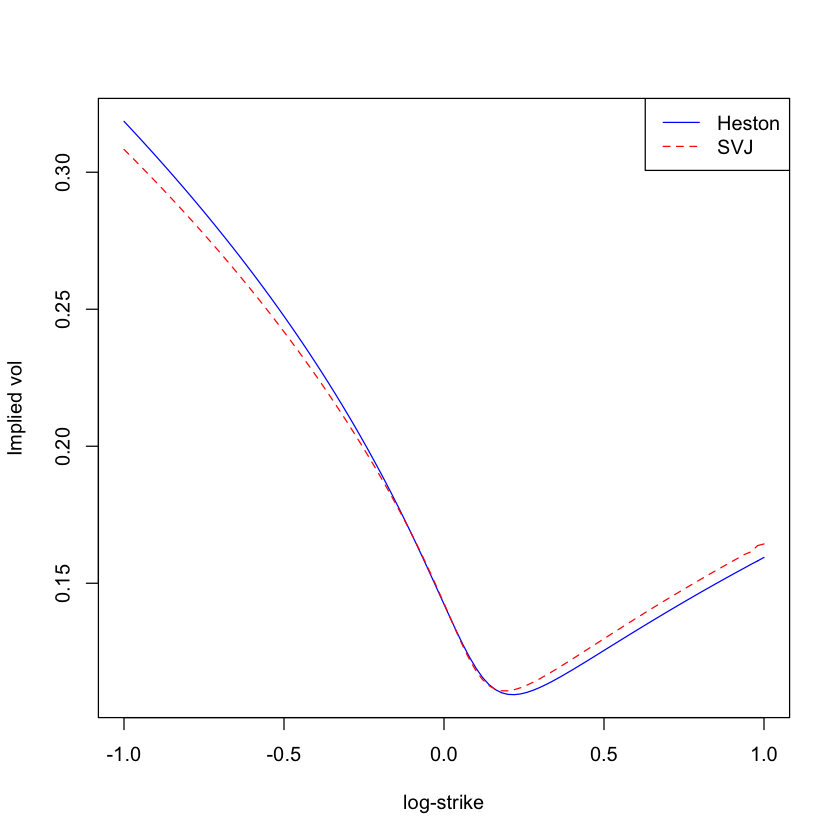

In [12]:
### SVJ characteristic function
phiSVJ <- function(params){
    
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    
    function(u, t){
        psiu <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))   
        return(phiHeston(params)(u,t)*exp(psiu*t)) 
        }
}

### parameters
subSVJ <- list(lambdaJ = 0.1308, alpha = -0.1151, delta = 0.0967,
              lambda = 0.5394,eta = 0.3038, rho = -0.6974, vbar = 0.0439,v = 0.0158) 
subHeston<-list(lambda = 1.3253,eta = 0.3877, rho = -0.7165, vbar = 0.0354,v = 0.0174)

### vectorize
volHeston<-function(k){sapply(k,function(k){bsvol(phiHeston(subHeston),k, t=1)})}
volSVJ<-function(k){sapply(k,function(k){bsvol(phiSVJ(subSVJ),k,t=1)})}

### plot
curve(volHeston(x),from=-1,to=1,col="blue",ylab="Implied vol", xlab="log-strike")
curve(volSVJ(x),from=-1,to=1,col="red",add=T,lty=2)
legend("topright",c("Heston","SVJ"),col=c("blue","red"),lty=c(1,2))

(b)

In [19]:
library(stinepack);

plotIvols <- function(ivolData,slices=NULL){

	bidVols <- as.numeric(ivolData$Bid);
	askVols <- as.numeric(ivolData$Ask);
	expDates <- unique(ivolData$Texp);
	nSlices <- length(expDates);
	if(!is.null(slices)) {nSlices <- length(slices)} else {slices <- 1:nSlices};
	colnum <- sqrt(nSlices*2);
	rows <- round(colnum/2,0);
	columns <- round(colnum,0);
	while(rows*columns < nSlices) {rows <- rows+1;}

	###############################################################################################################
	#Plot all the slices
	par(mfrow=c(rows,columns),mex=0.5)
	for (slice in slices){
		t <- expDates[slice];
		texp <- ivolData$Texp;
		bidVol <- bidVols[texp==t];
		askVol <- askVols[texp==t];
		midVol <- (bidVol+askVol)/2;
		f <- (ivolData$Fwd[texp==t])[1];
		k <- log(ivolData$Strike[texp==t]/f); # Plot vs log-strike
		include <- !is.na(bidVol);
		kmin <- min(k[include]);
		kmax <- max(k[include]);
		ybottom <- 0.8*min(bidVol[include]);
		ytop <- 1.2*max(askVol[include],na.rm=T);
		xrange <- c(kmin,kmax);
		yrange <- c(ybottom,ytop);

		plot(k,bidVol,col="red",pch=18,cex=.5, xlim=xrange,ylim=yrange,main=paste("T =",format(t,digits=2,nsmall=2)),xlab="Log-Strike",ylab="Implied Vol.");
        points(k,askVol,col="blue",pch=18,cex=.5,xlim=xrange,ylim=yrange,main=NA,xlab=NA,ylab=NA);
        
        volHeston<-function(k){sapply(k,function(k){bsvol(phiHeston(subHeston),k, t)})}
        volSVJ<-function(k){sapply(k,function(k){bsvol(phiSVJ(subSVJ),k,t)})}
        lines(k,volHeston(k),col="orange")
        lines(k,volSVJ(k),col="green")
        legend("topright",c("Heston","SVJ"),col=c("orange","green"),lty=1)
    }
}

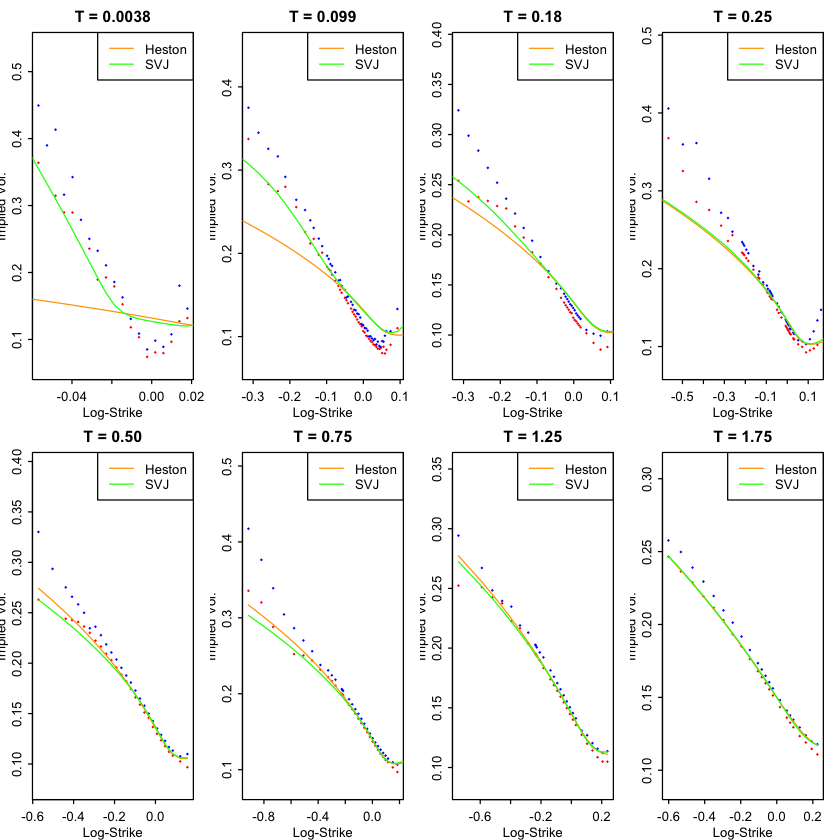

In [20]:
plotIvols(spxOptData)

(c)
<br/>For longer time to expiration, both Heston and SVJ fit well to the empirical vol surface.
<br/>For very short time to expiration, SVJ fits much better than Heston does, since it incorporates jumps in the underlying dynamics.

## Stochastic time change

### 2. (8 points) 

Consider the following model of the stock price:

$$
S_t = S_0\,\exp\left\{\sigma\,W(\tau_t)-\frac12\,\sigma^2\,\tau_t\right\}
$$

where $W(\tau_t)$ is time-changed Brownian motion.  The time-change $\tau$ is given by

$$
\tau_t = 
\left\{
\begin{array}{ll}
 \theta_1\,t& \text{ with probability } 1/2  \\
\theta_2\,t & \text{ with probability } 1/2.
\end{array}
\right.
$$

Note that the time-change is independent of the Brownian motion $W$.

(a)

Compute the characteristic function 

$$
\phi_{\tau_t}(u) = \ee{e^{i\,u\,\tau_t}}
$$

of the time-change.

(b)

Use equation (5) of Lecture 7 to compute the characteristic function 

$$
\phi_T(u) = \ee{e^{i\,u\,x_T}}= \frac 12 \,\left\{e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_1\,T}+ e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_2\,T} \right\}.
$$

with $x_t = \log S_t/S_0$.

(c)

Without explicit computation, deduce the fair value $C(S,K,T)$ of a European-style call option with strike $K$ and time to expiry $T$ in this model.

Hint: Note that the characteristic function is the sum of two simple ones.

(d) Rederive your result in part (c) by conditioning on total variance, Hull-White style.

### Answer
(a)
$$
\phi_{\tau_t}(u) = \ee{e^{i\,u\,\tau_t}}=\frac{1}{2}e^{i\,u\,\theta_1 t}+\frac{1}{2}e^{i\,u\,\theta_2 t}
$$
(b)
$$
x_T=\log\left(\frac{S_T}{S_0}\right)=\sigma W(\tau_T)-\frac{1}{2}\sigma^2\tau_T
$$
Define another process $y_t$, $y_t=\sigma W(t)-\frac{1}{2}\sigma^2t$, then $x_T=y_{\tau_T}$
$$
y_1\sim N\left(-\frac{1}{2}\sigma^2,\sigma^2\right)
$$
The characteristic exponent of $y_1$ is,
$$
\psi_{y_1}(u)=\log\ee{e^{i\,u\,y_1}}=-\frac{1}{2}iu\sigma^2-\frac{1}{2}u^2\sigma^2=-\frac{1}{2}u(u+i)\sigma^2
$$
<br/>By equation (5),
$$
\phi_T(u)=\phi_{\tau_T}\left(-i\psi_{y_T}(u)\right)=\phi_{\tau_T}\left(\frac{1}{2}iu(u+i)\sigma^2\right)=\frac 12 \,\left\{e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_1\,T}+ e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_2\,T} \right\}
$$
(c)
<br/>The characteristic function is the simple average of two Black-Scholes characteristic functions with different maturities or total variances. As we can see from equation (6) in Lecture 6, $C(S,K,T)$ is linear in characteristic funciton. So $C(S,K,T)$ is also the simple average of two Black-Scholes pricing formula.
$$
C(S,K,T)=\frac{1}{2}\left[C_{BS}\left(\log(K/S),\sigma^2\theta_1T\right)+C_{BS}\left(\log(K/S),\sigma^2\theta_2T\right)\right]
$$
$C_{BS}$ is a function of log-strike and total variance.

(d)
$$
w_T = 
\left\{
\begin{array}{ll}
 \sigma^2\theta_1\,T& \text{ with probability } 1/2  \\
\sigma^2 \theta_2\,T & \text{ with probability } 1/2.
\end{array}
\right.
$$
Since the time-change is independent of the Brownian motion, conditioning on total variance $w_T$,
$$
C(S,K,T)=\int C_{BS}\left(\log(K/S),w_T\right)p(w_T)dw_T=\frac{1}{2}\left[C_{BS}\left(\log(K/S),\sigma^2\theta_1T\right)+C_{BS}\left(\log(K/S),\sigma^2\theta_2T\right)\right]
$$